This notebook analyzes the MTA subway data for the week of June 10-17, 2017 that can be found here:

http://web.mta.info/developers/turnstile.html

The cell below reads the data in and lists the first few rows:

In [1]:
import pandas as pd

df = pd.read_csv('turnstile_June_17_2017.csv')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,00:00:00,REGULAR,6215258,2104297
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,04:00:00,REGULAR,6215284,2104303
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,08:00:00,REGULAR,6215318,2104337
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,12:00:00,REGULAR,6215475,2104417
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,16:00:00,REGULAR,6215841,2104465


How big is the data set?

In [2]:
df.shape

(197209, 11)

More specifically, how many stations and turnstiles are there?

In [3]:
stations = len(set(df["STATION"]))

turnstiles = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['SCP'] + ' ' + df['STATION']
turnstiles = len(set(turnstiles))

entries = 7 * 6 * turnstiles # 7 days, 6 data points per day

print('stations', stations)
print('turnstiles', turnstiles)
print('entries', entries)

stations 376
turnstiles 4695
entries 197190


What are the column names?

In [4]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

We can see that there is a lot of whitespace at the end of the exits column name. Let's strip that whitespace:

In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

What data types are each of the columns?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197209 entries, 0 to 197208
Data columns (total 11 columns):
C/A         197209 non-null object
UNIT        197209 non-null object
SCP         197209 non-null object
STATION     197209 non-null object
LINENAME    197209 non-null object
DIVISION    197209 non-null object
DATE        197209 non-null object
TIME        197209 non-null object
DESC        197209 non-null object
ENTRIES     197209 non-null int64
EXITS       197209 non-null int64
dtypes: int64(2), object(9)
memory usage: 16.6+ MB


We can see that the exits and entries are treated as integers but the others are all treated as objects (strings). Let's convert the time and date columns to datetime objects (so that the dates have a chronological order). 

In [38]:
df['TIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%m/%d/%Y %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-06-10,2017-06-10 00:00:00,REGULAR,6215258,2104297
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-06-10,2017-06-10 04:00:00,REGULAR,6215284,2104303
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-06-10,2017-06-10 08:00:00,REGULAR,6215318,2104337
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-06-10,2017-06-10 12:00:00,REGULAR,6215475,2104417
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-06-10,2017-06-10 16:00:00,REGULAR,6215841,2104465


What is the earliest and latest date in our dataset?

In [78]:
print(min(df['DATE']),max(df['DATE']))

2017-06-10 00:00:00 2017-06-16 00:00:00


If we wanted to only look at the 34st Street Penn Station stop on 6/12/2017, we could type the following:

In [39]:
from datetime import datetime as dt
date = dt(2017, 6, 12, 0, 0, 0)
penn = df[(df['STATION'] == '34 ST-PENN STA') & (df['DATE'] == date)]
penn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
49612,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2017-06-12,2017-06-12 00:00:00,REGULAR,1829493,1553798
49613,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2017-06-12,2017-06-12 04:00:00,REGULAR,1829495,1553801
49614,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2017-06-12,2017-06-12 08:00:00,REGULAR,1829676,1553947
49615,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2017-06-12,2017-06-12 12:00:00,REGULAR,1829944,1554414
49616,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,2017-06-12,2017-06-12 16:00:00,REGULAR,1829981,1554571


## Data Preparation
In this section, I will store all data by (C/A,UNIT,STATION) then by SCP then by date and time. The purpose of this section is to prepare data for later uses. It takes a little while to finish running:

In [40]:
bigDict = {}
for i,row in df.iterrows():
    t1 = (row["C/A"],row["UNIT"],row["STATION"])
    t2 = row["SCP"]
    t3 = (row["TIME"],row["EXITS"])
    if t1 not in bigDict:
        bigDict[t1] = {}
    if t2 not in bigDict[t1]:
        bigDict[t1][t2] = []
    bigDict[t1][t2].append(t3)
    bigDict[t1][t2].sort() #This line is NOT necessary if our dataframe is sorted in correct chonological order
print("Done!")

Done!


For example, if we wanted to see all of the turnstile data located at the 'N203', 'R195', '161/YANKEE STAD' area, we could type:

In [41]:
bigDict[('N203', 'R195', '161/YANKEE STAD')]

{'00-00-00': [(Timestamp('2017-06-10 00:22:00'), 5150121),
  (Timestamp('2017-06-10 04:22:00'), 5150151),
  (Timestamp('2017-06-10 08:22:00'), 5150221),
  (Timestamp('2017-06-10 12:22:00'), 5150396),
  (Timestamp('2017-06-10 16:22:00'), 5150735),
  (Timestamp('2017-06-10 20:22:00'), 5151577),
  (Timestamp('2017-06-11 00:22:00'), 5151763),
  (Timestamp('2017-06-11 04:22:00'), 5151790),
  (Timestamp('2017-06-11 08:22:00'), 5151842),
  (Timestamp('2017-06-11 12:22:00'), 5152221),
  (Timestamp('2017-06-11 16:22:00'), 5152726),
  (Timestamp('2017-06-11 20:22:00'), 5152920),
  (Timestamp('2017-06-12 00:22:00'), 5153021),
  (Timestamp('2017-06-12 04:22:00'), 5153041),
  (Timestamp('2017-06-12 08:22:00'), 5153203),
  (Timestamp('2017-06-12 12:22:00'), 5153450),
  (Timestamp('2017-06-12 16:22:00'), 5153786),
  (Timestamp('2017-06-12 20:22:00'), 5154182),
  (Timestamp('2017-06-13 00:22:00'), 5154279),
  (Timestamp('2017-06-13 04:22:00'), 5154293),
  (Timestamp('2017-06-13 08:22:00'), 5154451),
 

## Finding Data Errors
Due to bugs in MTA data, this section is used to remove "incorrect" data. First, we find the incorrect data by seeing which turnstile counters aren't going strictly upwards:

In [42]:
print(len(bigDict))
trouble = {}
for st,stv in bigDict.items():
    for scp,lst in stv.items():
        #Cleaning in Each LIST of turnstile
        toDel = []
        n = len(lst)
        lst.sort()
        for i in range(1,n-1):
            if(lst[i-1][1]<=lst[i][1] and lst[i][1]<=lst[i+1][1]): #What we expected Data to be (Non-Decreasing)
                continue
                
            key = (st,scp)
            trouble[key] = trouble.get(key,0)+1
print("Trouble List: ",len(trouble.keys()))
for k,v in trouble.items():
    print(k,v)

732
Trouble List:  59
(('A011', 'R080', '57 ST-7 AV'), '01-00-00') 41
(('A011', 'R080', '57 ST-7 AV'), '01-00-03') 41
(('A043', 'R462', 'CANAL ST'), '00-06-00') 2
(('A060', 'R001', 'WHITEHALL S-FRY'), '00-00-06') 2
(('A069', 'R044', 'CHAMBERS ST'), '01-06-00') 2
(('A069', 'R044', 'CHAMBERS ST'), '01-06-01') 36
(('B020', 'R263', 'AVENUE H'), '00-05-00') 2
(('B024', 'R211', 'KINGS HWY'), '00-05-01') 2
(('B025', 'R150', 'AVENUE U'), '00-00-01') 2
(('C021', 'R212', '59 ST'), '00-00-02') 40
(('D008', 'R392', '18 AV'), '00-00-02') 40
(('H003', 'R163', '6 AV'), '01-00-02') 39
(('H009', 'R235', 'BEDFORD AV'), '00-06-05') 2
(('JFK02', 'R535', 'HOWARD BCH JFK'), '01-00-03') 2
(('JFK03', 'R536', 'JFK JAMAICA CT1'), '00-03-00') 2
(('JFK03', 'R536', 'JFK JAMAICA CT1'), '00-03-02') 2
(('J034', 'R007', '104 ST'), '00-00-01') 40
(('J034', 'R007', '104 ST'), '00-00-02') 32
(('K026', 'R100', 'METROPOLITAN AV'), '00-00-01') 40
(('N016A', 'R296', '163 ST-AMSTERDM'), '00-00-01') 40
(('N029', 'R333', '116 S

I plot the data to make the data accessible to human eyes. Here's an example:

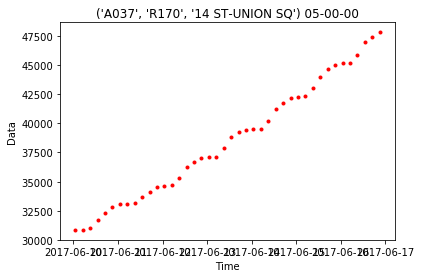

In [43]:
import matplotlib.pyplot as plt
def inspection(stationInfo,scp):
    t = []
    r = []
    for v in bigDict[stationInfo][scp]:
        t.append(v[0])
        r.append(v[1])
    plt.plot(t,r,".r")
    plt.title(str(stationInfo)+" "+scp)
    plt.xlabel("Time")
    plt.ylabel("Data")
    plt.show()
    
def inspection2(tup):
    inspection(tup[0],tup[1])
    

inspection2((('A037', 'R170', '14 ST-UNION SQ'), '05-00-00'))

These are plots of all of the turnstiles that are troublesome:

All Trouble
Total Trouble: 59


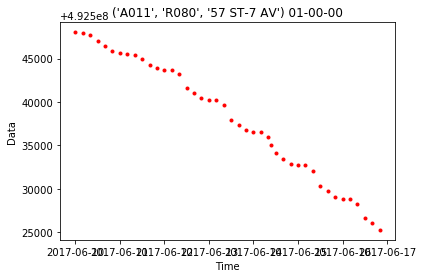

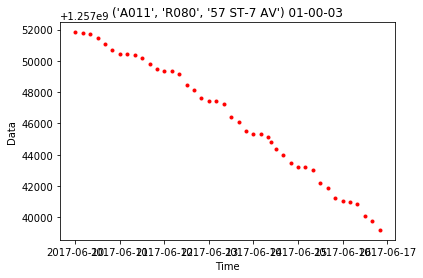

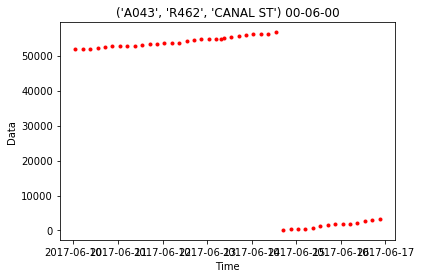

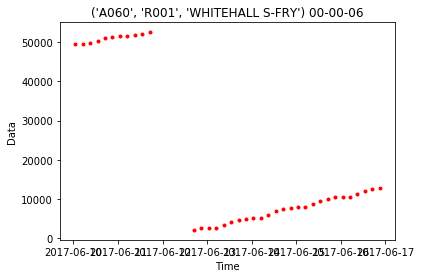

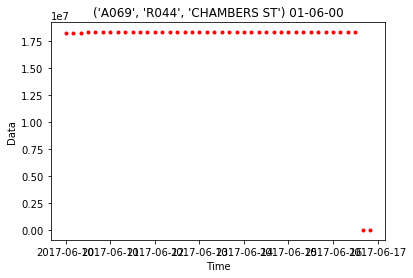

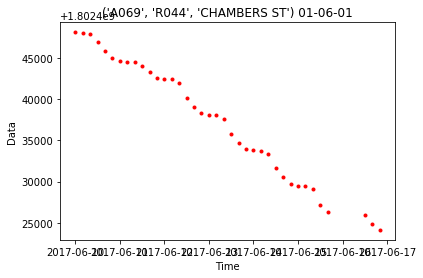

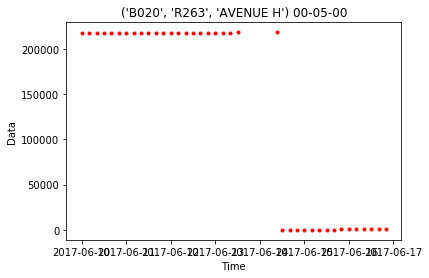

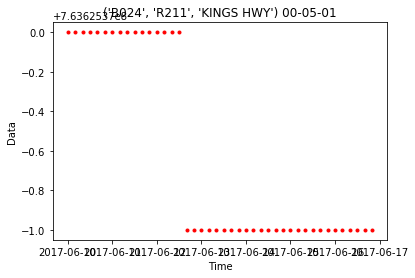

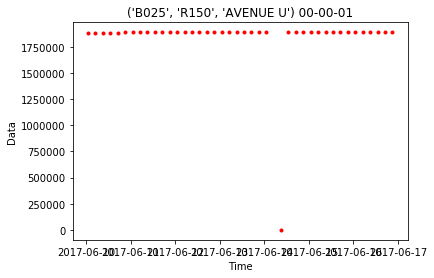

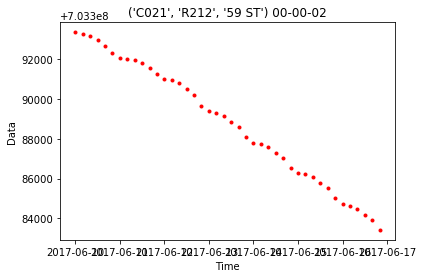

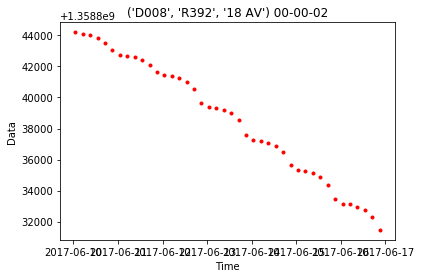

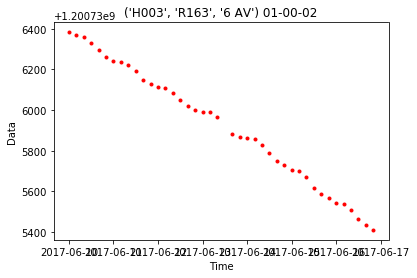

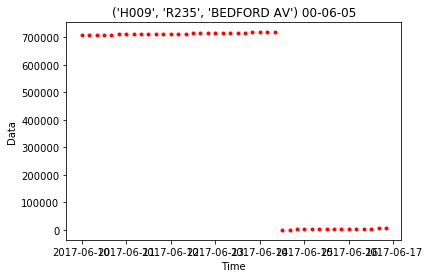

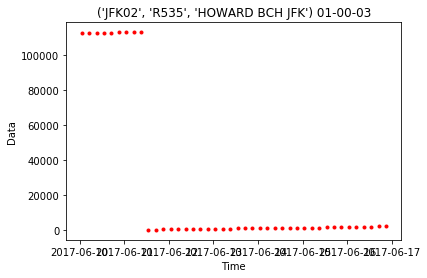

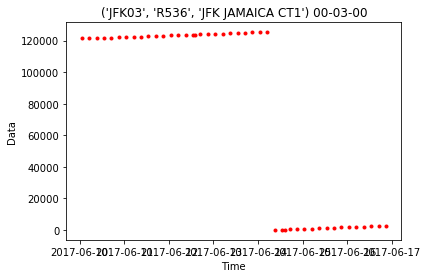

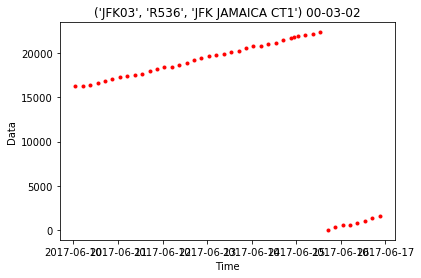

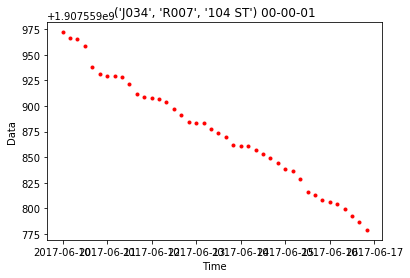

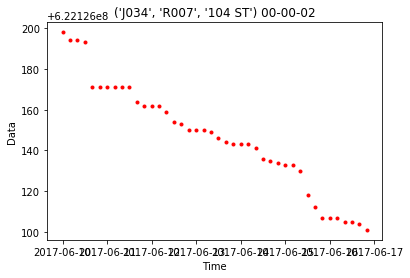

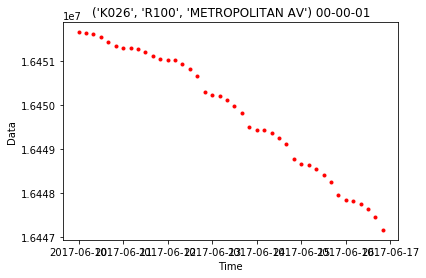

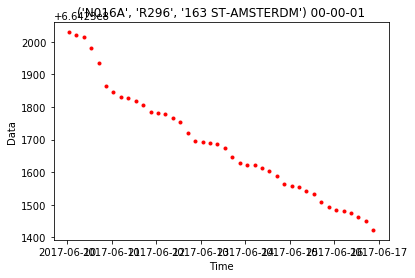

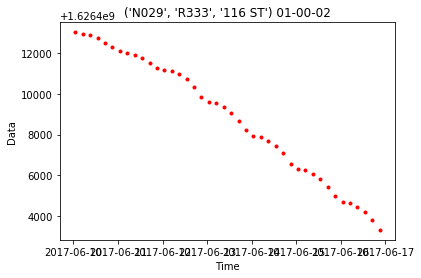

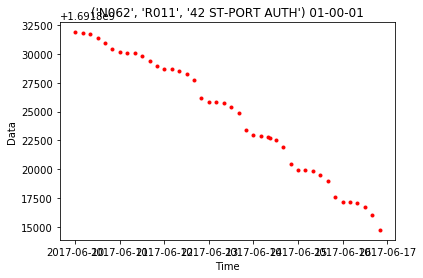

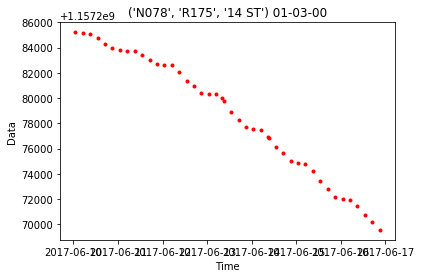

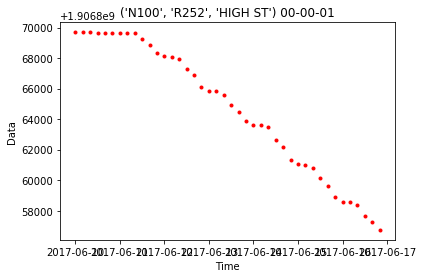

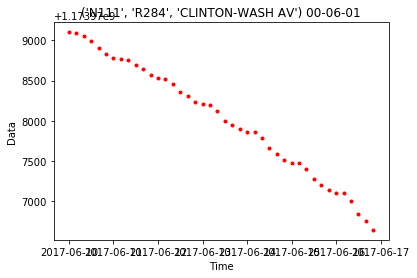

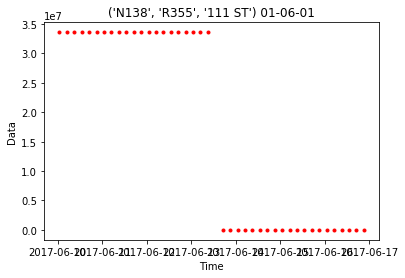

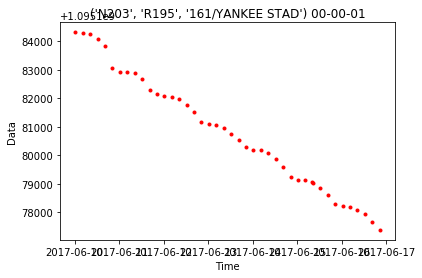

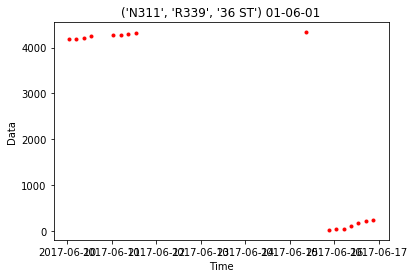

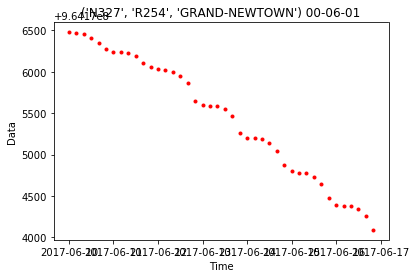

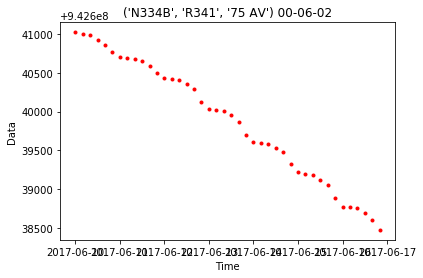

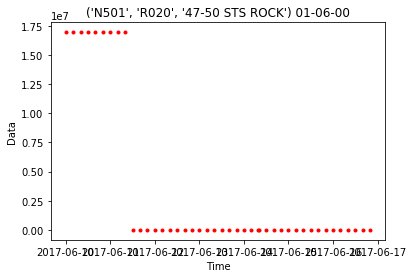

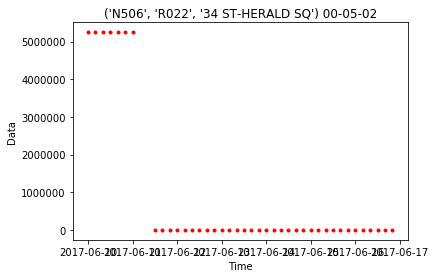

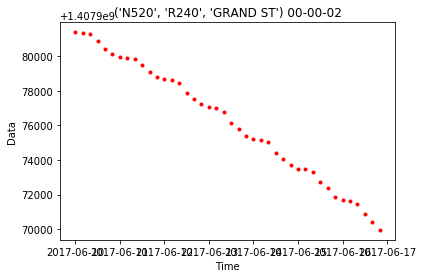

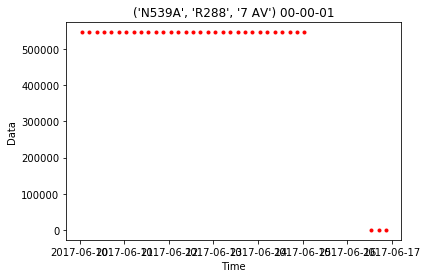

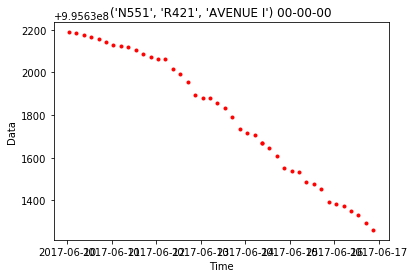

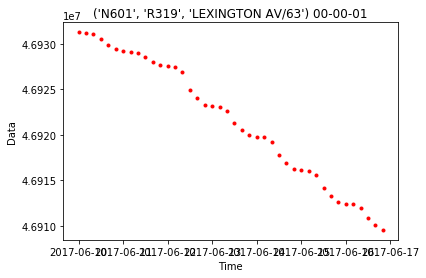

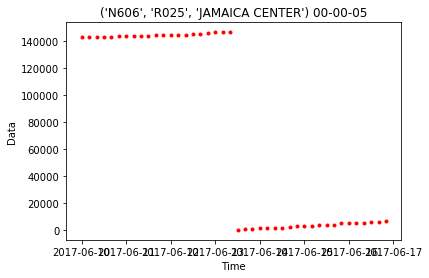

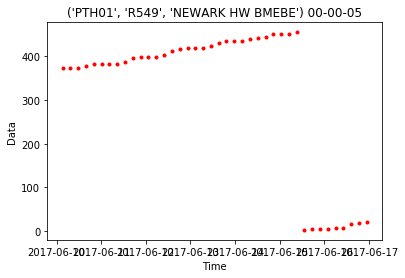

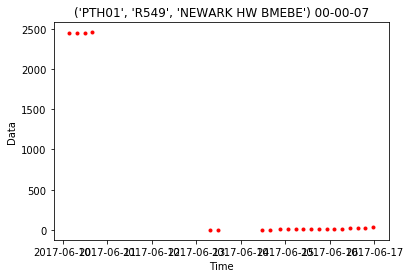

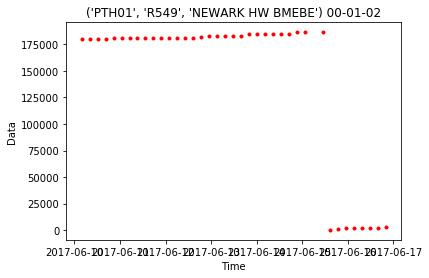

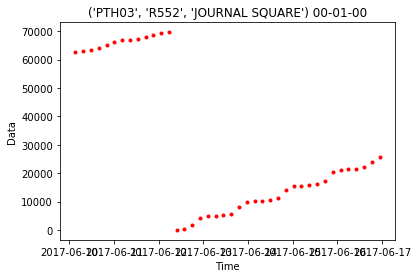

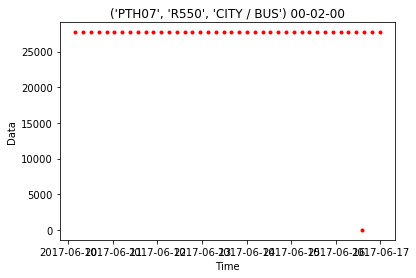

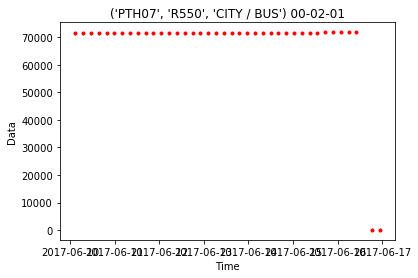

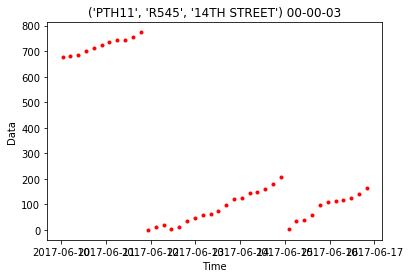

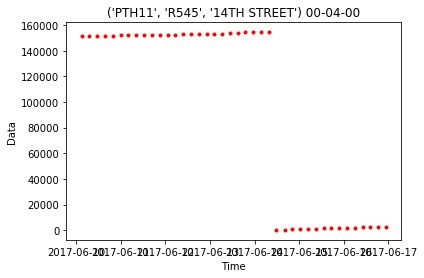

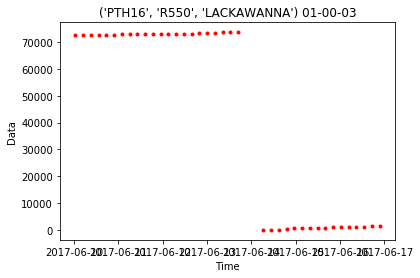

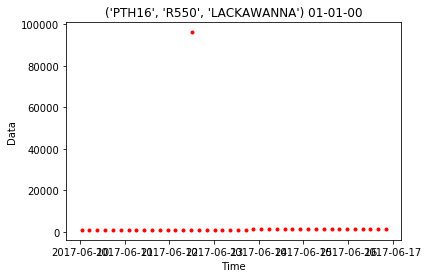

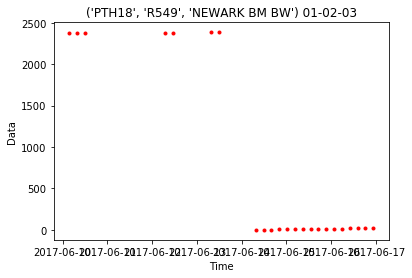

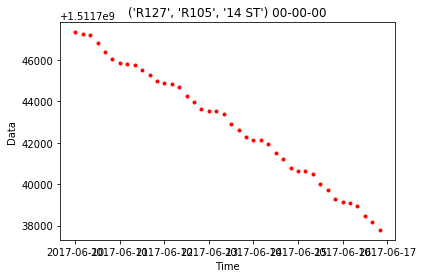

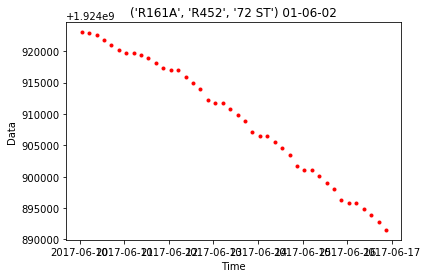

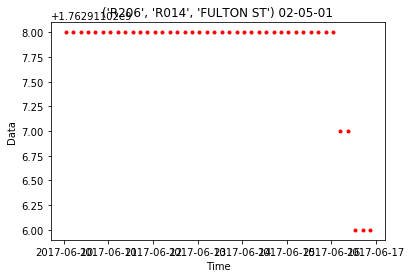

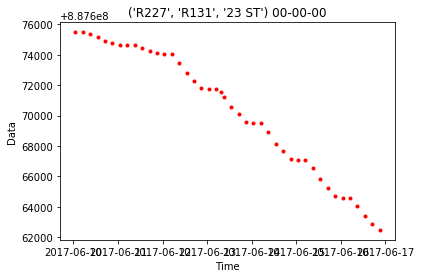

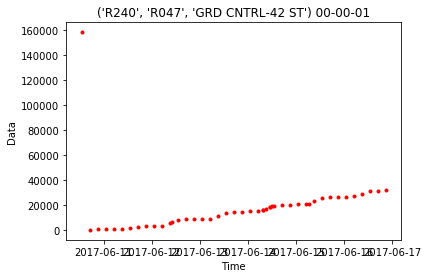

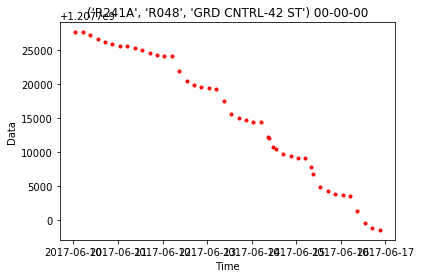

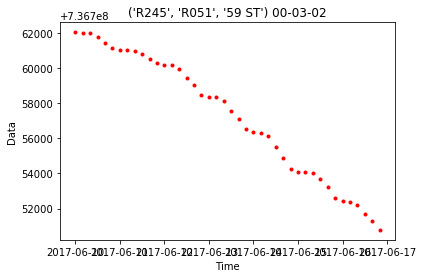

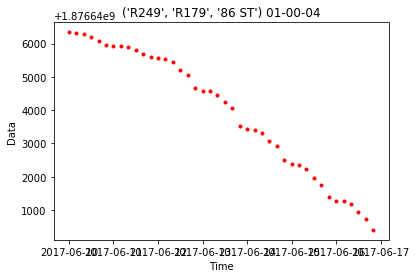

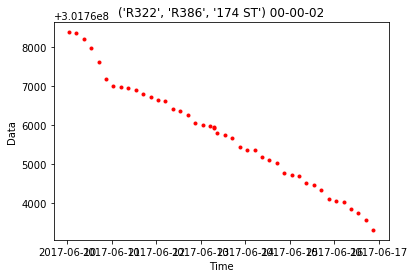

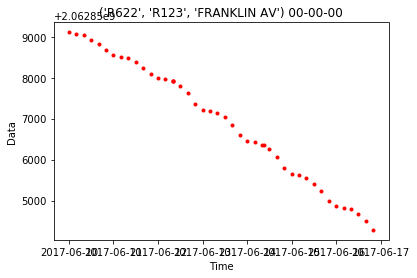

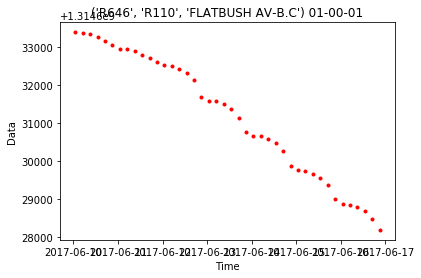

In [44]:
#All Trouble
print("All Trouble")
print("Total Trouble:",len(trouble))
for troubleStation in trouble.keys():
    inspection2(troubleStation)

## Data Cleanup
There are three types of mistakes: decreasing, garbage values, and turnstile resets.

#### Mistake Type I: Montone but Decreasing - To fix this, we reflect the data:

Total Monotone Decrease: 32
Problem Fixed!
Total Monotone Decrease: 32


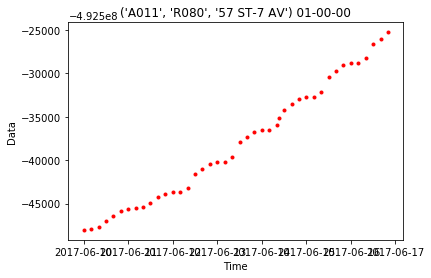

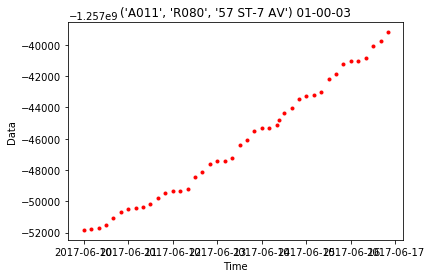

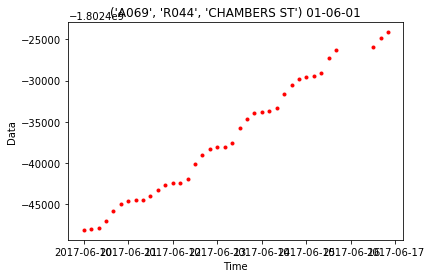

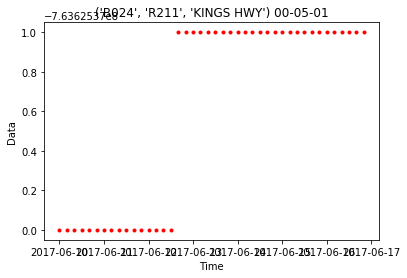

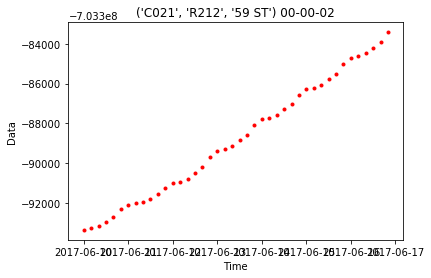

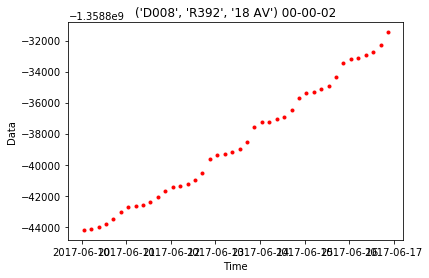

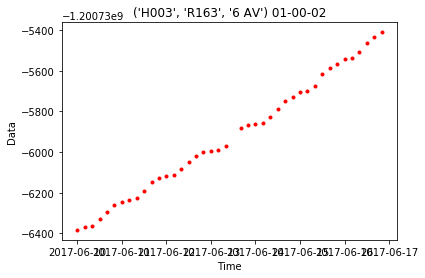

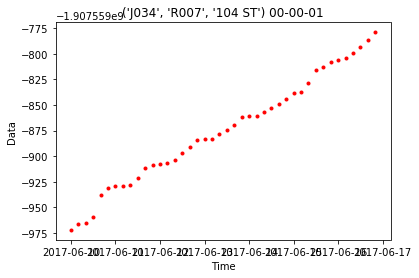

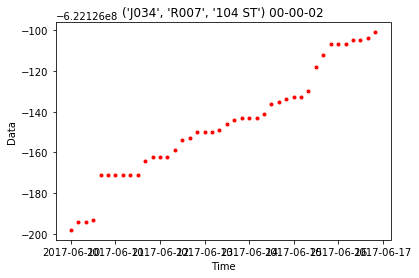

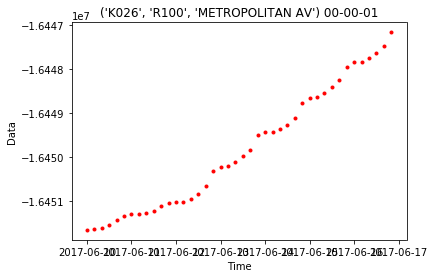

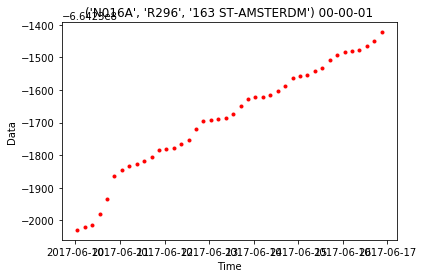

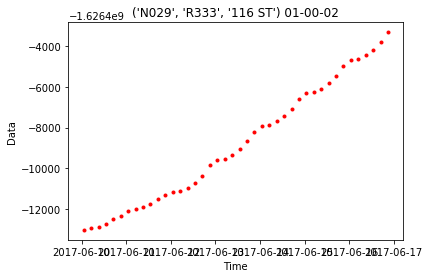

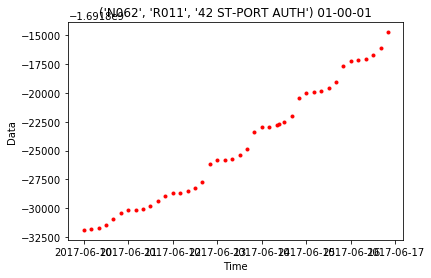

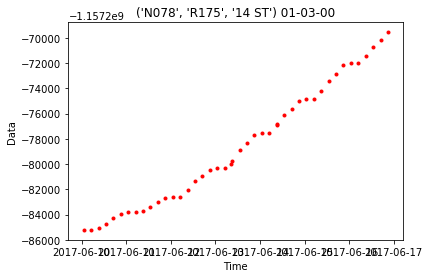

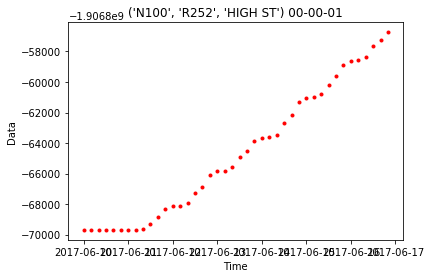

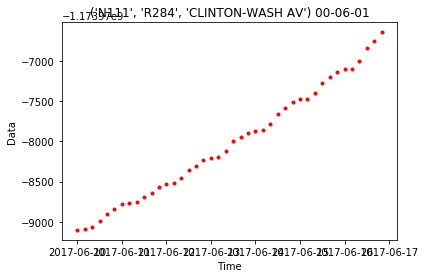

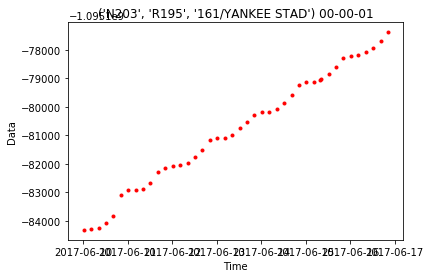

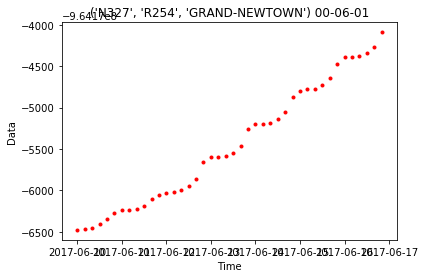

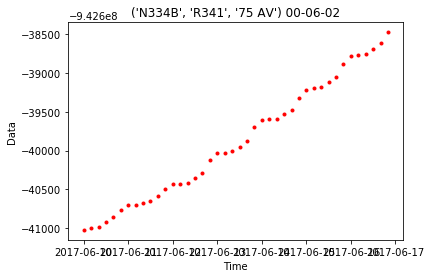

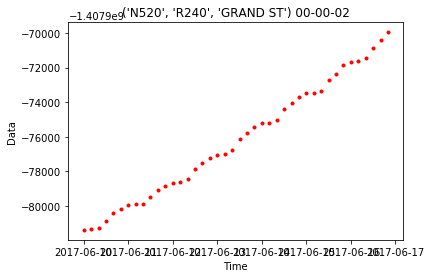

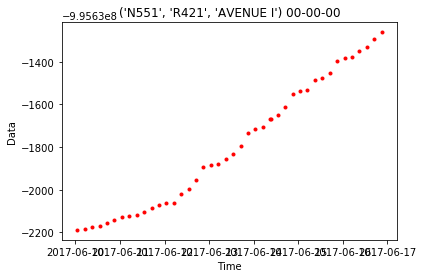

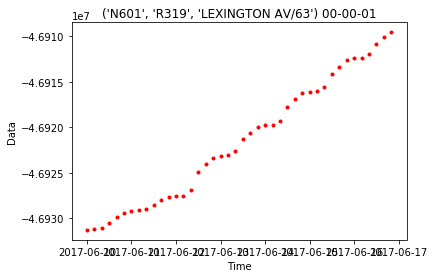

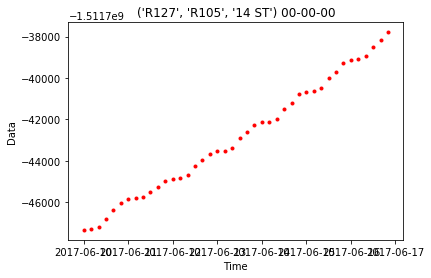

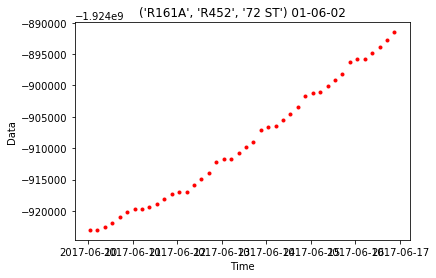

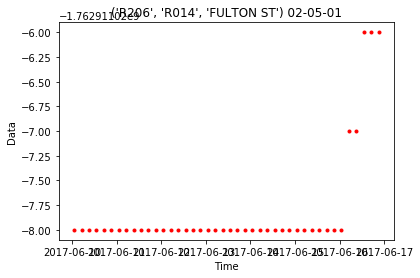

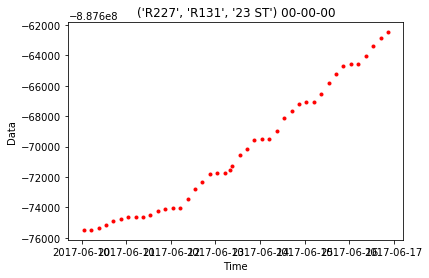

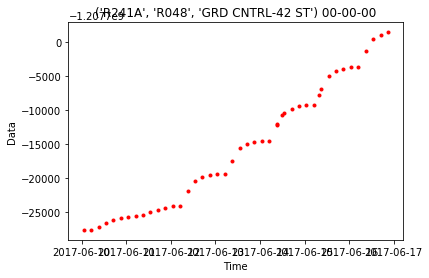

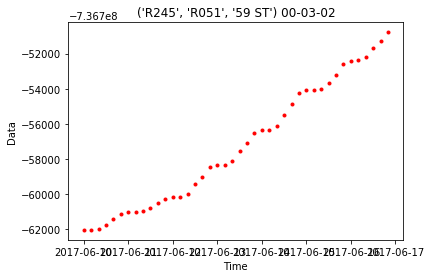

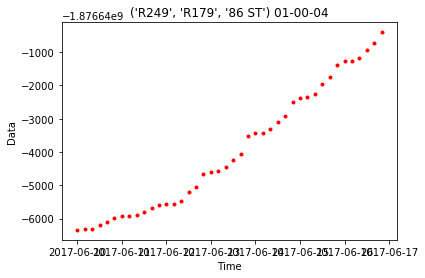

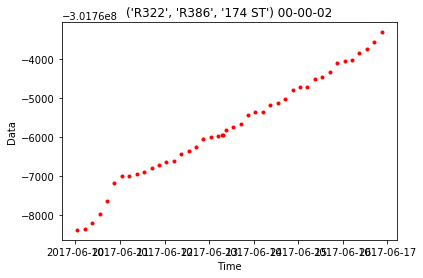

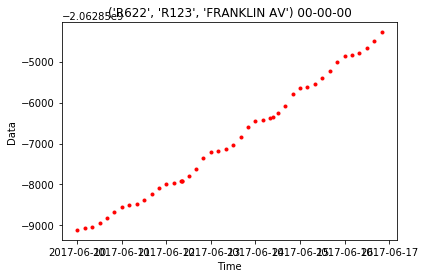

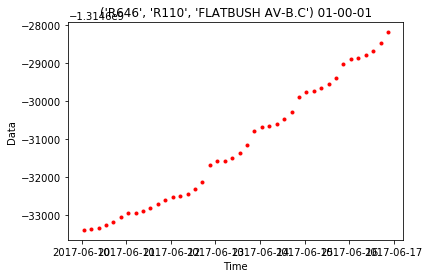

In [45]:
#Input: Tuple of (Station,SCP)
#Output: True if this SCP has monotone property, but decreasing, False otherwise.
def isMonotoneDecrease(tup):
    n = len(bigDict[tup[0]][tup[1]])
    for i in range(n-1):
        if(bigDict[tup[0]][tup[1]][i+1][1]>bigDict[tup[0]][tup[1]][i][1]):
            return False
    return True

def fixMonotoneDecrease(tup):
    n = len(bigDict[tup[0]][tup[1]])
    for i in range(n):
        bigDict[tup[0]][tup[1]][i] = (bigDict[tup[0]][tup[1]][i][0],(-1)*bigDict[tup[0]][tup[1]][i][1])
    

monotoneDecreaseList = []
for k in trouble:
    if(isMonotoneDecrease(k)):
        monotoneDecreaseList.append(k)
print("Total Monotone Decrease:",len(monotoneDecreaseList))
for k in monotoneDecreaseList:
    fixMonotoneDecrease(k)
print("Problem Fixed!")
#monotoneDecreaseList = []
for k in trouble:
    if(isMonotoneDecrease(k)):
        monotoneDecreaseList.append(k)
print("Total Monotone Decrease:",len(monotoneDecreaseList))
for k in monotoneDecreaseList:
    inspection2(k)

#### Mistake Type II: Garbage Value - To fix this, remove the garbage value

Garbage Removed: 3


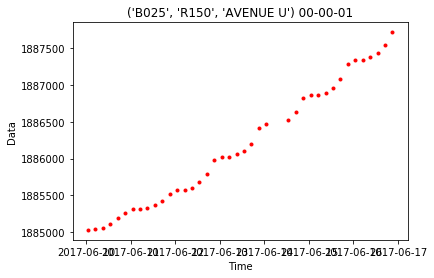

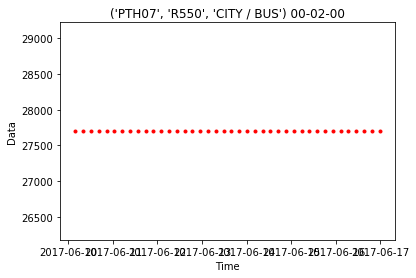

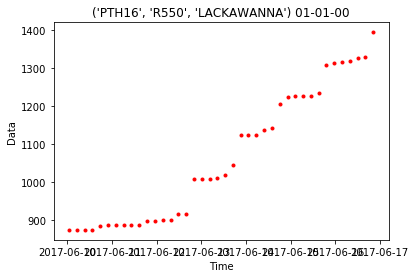

In [46]:
def garbageEliminator(tup):
    n = len(bigDict[tup[0]][tup[1]])
    toDel = []
    for i in range(1,n-1):
        if((bigDict[tup[0]][tup[1]][i-1][1]>bigDict[tup[0]][tup[1]][i+1][1])):
            continue
        if((bigDict[tup[0]][tup[1]][i-1][1]<=bigDict[tup[0]][tup[1]][i][1]) and (bigDict[tup[0]][tup[1]][i][1]<=bigDict[tup[0]][tup[1]][i+1][1])):
            continue
        toDel.append(bigDict[tup[0]][tup[1]][i])
    #Deletion Process
    if(len(toDel)==0):
        return 0
    for k in toDel:
        bigDict[tup[0]][tup[1]].remove(k)
    return 1


#Driver
cnt = 0
healList = []
for k in trouble:
    if(garbageEliminator(k)):
        healList.append(k)
print("Garbage Removed:",len(healList))
for k in healList:
    inspection2(k)

#### Mistake Type III: Turnstile Reset - To fix this, shift the data upwards.

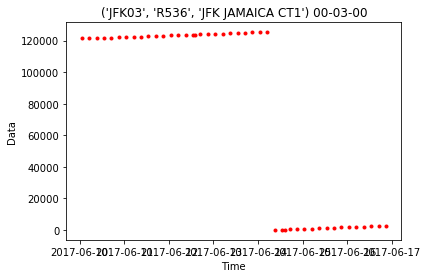

Cleaned


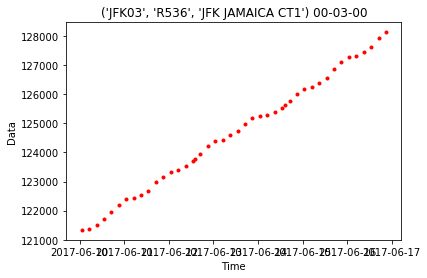

In [47]:
def dealingWithReset(tup):
    sta = tup[0]
    tsl = tup[1]
    n = len(bigDict[sta][tsl])
    #Detecting Part
    resetPoint = [] # it means (i,i+1) is reset
    resetSet = []
    for i in range(1,n-2):
        if(bigDict[sta][tsl][i][1]<=bigDict[sta][tsl][i+1][1]):
            continue #We don't need to change this one
        resetPoint.append(i)
    #Fixing Part
    resetSet = set(resetPoint)
    cumulative = 0
    for i in range(n-2):
        if(i not in resetSet):
            bigDict[sta][tsl][i] = (bigDict[sta][tsl][i][0],bigDict[sta][tsl][i][1]+cumulative)
            continue
        #Problem
        expected = (bigDict[sta][tsl][i][1]-bigDict[sta][tsl][i-1][1])+ (bigDict[sta][tsl][i+2][1]-bigDict[sta][tsl][i+1][1])
        expected = int(expected/2)
        shift = (bigDict[sta][tsl][i][1]+expected)-bigDict[sta][tsl][i+1][1]
        cumulative = shift
    for i in range(n-2,n):
        bigDict[sta][tsl][i] = (bigDict[sta][tsl][i][0],bigDict[sta][tsl][i][1]+cumulative)
    #Done!
    
#Test Usage
inspection2((('JFK03', 'R536', 'JFK JAMAICA CT1'), '00-03-00'))
dealingWithReset((('JFK03', 'R536', 'JFK JAMAICA CT1'), '00-03-00'))
print("Cleaned")
inspection2((('JFK03', 'R536', 'JFK JAMAICA CT1'), '00-03-00'))

## Overall Cleaning Process
This next cell does all of the previous cleanup in one cell:

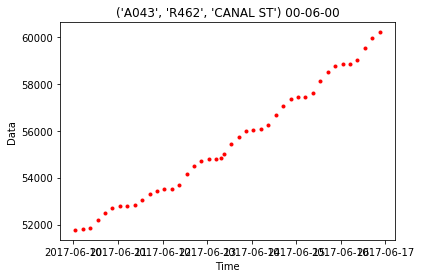

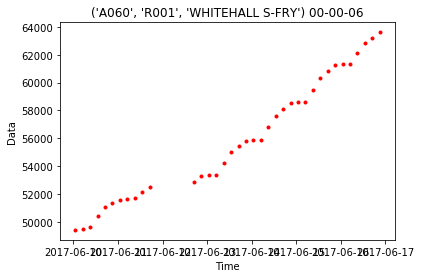

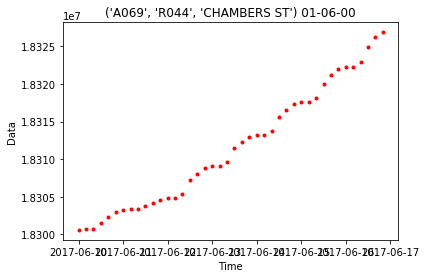

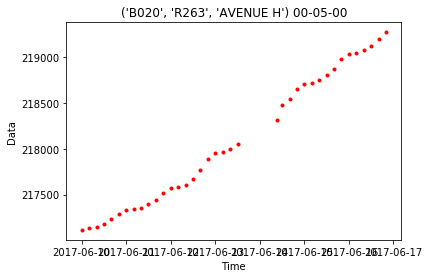

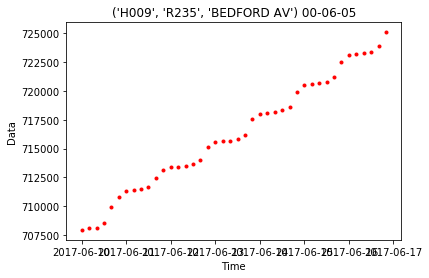

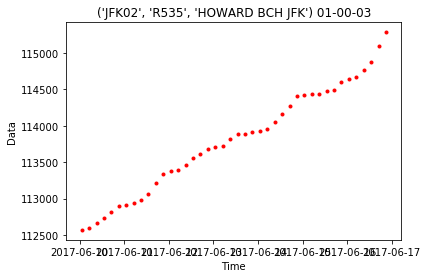

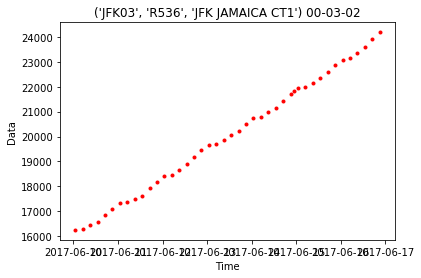

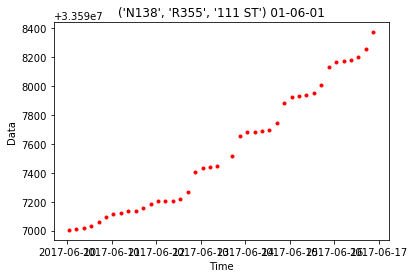

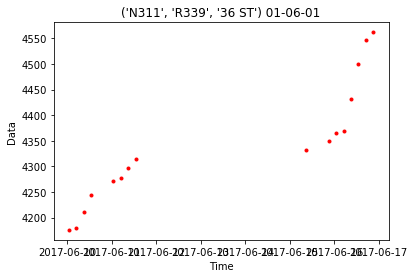

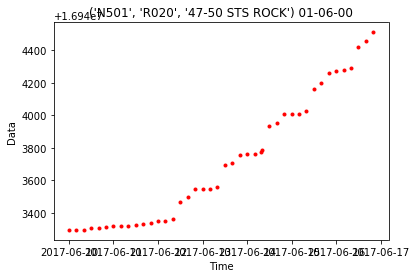

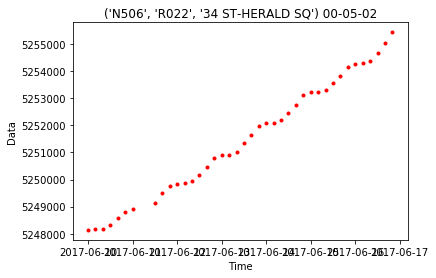

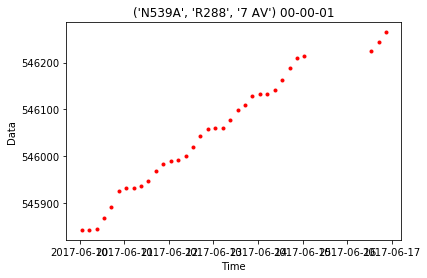

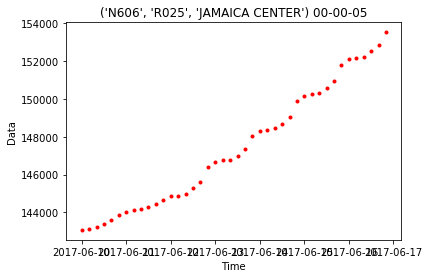

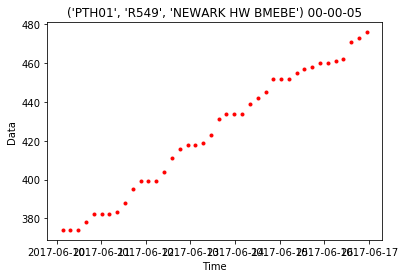

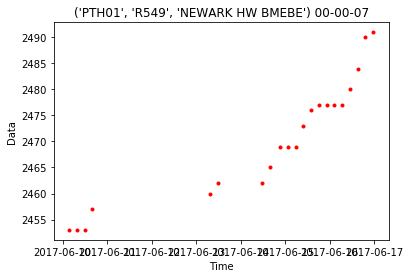

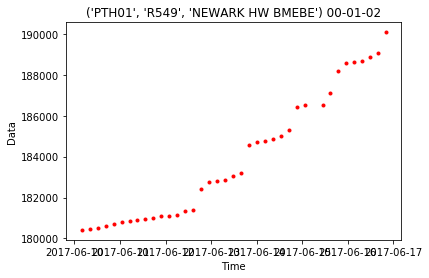

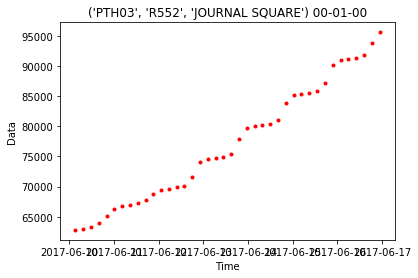

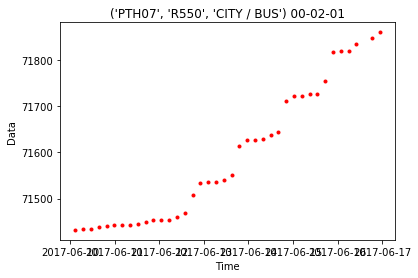

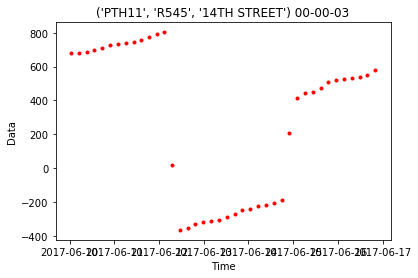

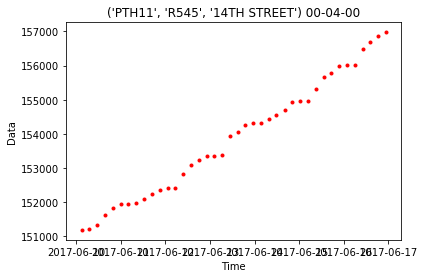

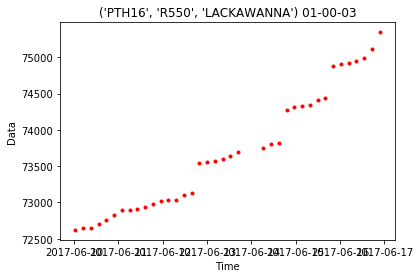

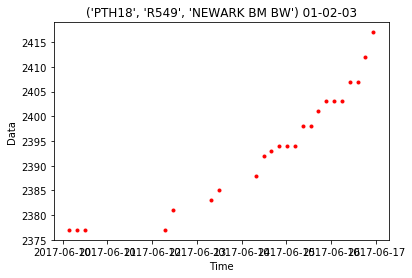

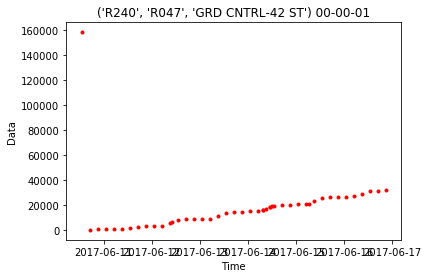

In [48]:
toClean = {}
for st,stv in bigDict.items():
    for scp,lst in stv.items():
        #Cleaning in Each LIST of turnstile
        toDel = []
        n = len(lst)
        lst.sort()
        for i in range(1,n-1):
            if(lst[i-1][1]<=lst[i][1] and lst[i][1]<=lst[i+1][1]): #What we expected Data to be (Non-Decreasing)
                continue

            key = (st,scp)
            toClean[key] = trouble.get(key,0)+1
            
for k in toClean.keys():
    if(isMonotoneDecrease(k)):
        fixMonotoneDecrease(k)
    garbageEliminator(k)
    dealingWithReset(k)
    inspection2(k)

Which troublesome stations are left?

In [80]:
trouble = {}
for st,stv in bigDict.items():
    for scp,lst in stv.items():
        #Cleaning in Each LIST of turnstile
        toDel = []
        n = len(lst)
        lst.sort()
        for i in range(1,n-1):
            if(lst[i-1][1]<=lst[i][1] and lst[i][1]<=lst[i+1][1]): #What we expected Data to be (Non-Decreasing)
                continue
                
            key = (st,scp)
            trouble[key] = trouble.get(key,0)+1
print("Trouble List: ",len(trouble.keys()))
for k,v in trouble.items():
    print(k,v)

Trouble List:  0


Let's delete these manually:

In [50]:
del bigDict[('PTH11', 'R545', '14TH STREET')]['00-00-03']
del bigDict[('R240', 'R047', 'GRD CNTRL-42 ST')]['00-00-01']
print("Deleted")

Deleted


The data is now all cleaned, so let's save it so that we don't have to run all of the above code every time.

In [53]:
import pickle
pickle.dump(bigDict, open( "MTAdict.pkl", "wb" ))

# ---At this point, the data is ready to use.---
Let's read the cleaned data file back in:

In [54]:
import pickle
bigDict = pickle.load( open( "MTAdict.pkl", "rb" ) )

### Specific Time Extraction Function
Input: List of a single **Turnstile**, Start Time, End Time

Output: **(Float)** Number of Riders for that day in that timeframe. **(Linear) Approximation** is used in case of incomplete information

In [55]:
from datetime import datetime as dt
def cleanPeople(n): #Just a cleanup function
    if(n<0):
        return 0
    if(n>10000):
        return 0
    return n

noDay = dt(2017,6,12,0,0,0)-dt(2017,6,12,0,0,0)
#print(noDay)


def getRangeRider(turnstileList,startTime,endTime):
    ret = 0 #Return Value
    n = len(turnstileList)
    totalTime = endTime-startTime
    #print("Total Time:",totalTime) #Debugging Purpose
    for i in range(n-1): #A list of N items has (N-1) consecutive pairs
        ti = turnstileList[i][0]
        tf = turnstileList[i+1][0]
        if((tf<startTime) or (ti>endTime)):
            continue #Non-overlap Time Segment
        #Overlapping Time
        segmentTime = min(tf,endTime) - max(ti,startTime)
        fullSegment = tf-ti
        if(fullSegment==noDay): #Dealing with Bug
            return 0
        weight = segmentTime/fullSegment
        peopleCount = turnstileList[i+1][1]-turnstileList[i][1]
        peopleCount = cleanPeople(peopleCount)
        #print("Considering",ti,"to",tf,"Weight:",weight,"Riders:",peopleCount) #Debugging Purpose
        ret+= (weight)*peopleCount
    return int(ret)


These are the number of people through the ('R204', 'R043', 'WALL ST')]["02-00-00"] turnstile between midnight of 6/12/17 and 6/13/17:

In [56]:
#Test
t1 = dt.strptime("2017-06-12 00:00:00","%Y-%m-%d %H:%M:%S")
t2 = dt.strptime("2017-06-13 00:00:00","%Y-%m-%d %H:%M:%S")
ans = int(getRangeRider(bigDict[('R204', 'R043', 'WALL ST')]["02-00-00"],t1,t2))
print(ans)

1419


To get the total station area info (instead of just a single turnstile info), we'll use the following function:

In [57]:
#This function take a dictionary of a station as a input, it will call getRangeRider for each turnstile
def getStationRangeRider(stationDict,startTime,endTime):
    #print("Riders between",startTime,endTime)
    ret = 0
    for k,v in stationDict.items():
        
        cur = getRangeRider(v,startTime,endTime)
        ret+= cur
        #print("Turnstile",k,":",cur)
    return ret

These are the number of people through the ('R204', 'R043', 'WALL ST')] area between midnight of 6/12/17 and 6/13/17:

In [58]:
#Example Usage
ans = getStationRangeRider(bigDict[('R204', 'R043', 'WALL ST')],dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0))
print(ans)

9507


Here is a plot of the total Wall St Station riders:

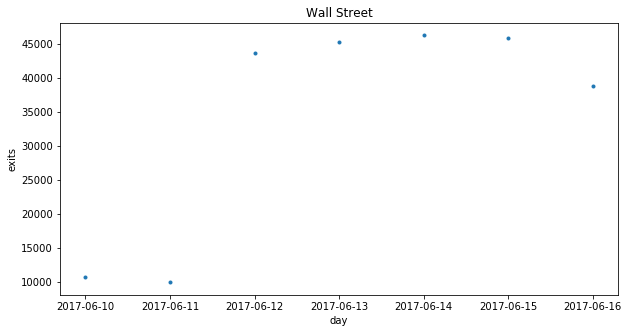

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

mon,tue,wed,thu,fri,sat,sun = 0,0,0,0,0,0,0

for station in bigDict.keys():
    if station[2] == 'WALL ST':
        sat = sat + getStationRangeRider(bigDict[station], dt(2017,6,10,0,0,0),dt(2017,6,11,0,0,0))
        sun = sun + getStationRangeRider(bigDict[station], dt(2017,6,11,0,0,0),dt(2017,6,12,0,0,0))
        mon = mon + getStationRangeRider(bigDict[station], dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0))
        tue = tue + getStationRangeRider(bigDict[station], dt(2017,6,13,0,0,0),dt(2017,6,14,0,0,0))
        wed = wed + getStationRangeRider(bigDict[station], dt(2017,6,14,0,0,0),dt(2017,6,15,0,0,0))
        thu = thu + getStationRangeRider(bigDict[station], dt(2017,6,15,0,0,0),dt(2017,6,16,0,0,0))
        fri = fri + getStationRangeRider(bigDict[station], dt(2017,6,16,0,0,0),dt(2017,6,17,0,0,0))
counts = [sat, sun, mon, tue, wed, thu, fri]   

days = [ dt(2017,6,10,0,0,0), 
        dt(2017,6,11,0,0,0), 
        dt(2017,6,12,0,0,0), 
        dt(2017,6,13,0,0,0), 
        dt(2017,6,14,0,0,0), 
        dt(2017,6,15,0,0,0), 
        dt(2017,6,16,0,0,0)]

plt.rcParams['figure.figsize'] = [10,5]
plt.plot(days, counts,'.')
plt.xlabel('day')
plt.ylabel('exits')
plt.title('Wall Street')

Sort by busiest stations during 6/12-6/13:

In [65]:
station_list = []
for station in bigDict.keys():
    station_list.append((getStationRangeRider(bigDict[station],dt(2017,6,12,0,0,0),dt(2017,6,13,0,0,0)), station))
station_list.sort(reverse = True)
station_list[0:20]

[(57270, ('PTH22', 'R540', 'PATH NEW WTC')),
 (54169, ('R238', 'R046', 'GRD CNTRL-42 ST')),
 (36343, ('R249', 'R179', '86 ST')),
 (35517, ('R240', 'R047', 'GRD CNTRL-42 ST')),
 (30835, ('R533', 'R055', 'FLUSHING-MAIN')),
 (28806, ('H009', 'R235', 'BEDFORD AV')),
 (28039, ('N324', 'R018', 'JKSN HT-ROOSVLT')),
 (27867, ('N500', 'R020', '47-50 STS ROCK')),
 (27437, ('A025', 'R023', '34 ST-HERALD SQ')),
 (27378, ('PTH03', 'R552', 'JOURNAL SQUARE')),
 (27245, ('R138', 'R293', '34 ST-PENN STA')),
 (26662, ('N506', 'R022', '34 ST-HERALD SQ')),
 (25941, ('N049', 'R084', '59 ST COLUMBUS')),
 (25865, ('R221', 'R170', '14 ST-UNION SQ')),
 (25506, ('N507', 'R023', '34 ST-HERALD SQ')),
 (25330, ('N063A', 'R011', '42 ST-PORT AUTH')),
 (24698, ('N083', 'R138', 'W 4 ST-WASH SQ')),
 (24668, ('A034', 'R170', '14 ST-UNION SQ')),
 (24245, ('N306', 'R017', 'LEXINGTON AV/53')),
 (23432, ('R169', 'R168', '96 ST'))]

Histogram of all of the station area exits between 6/12-6/13:

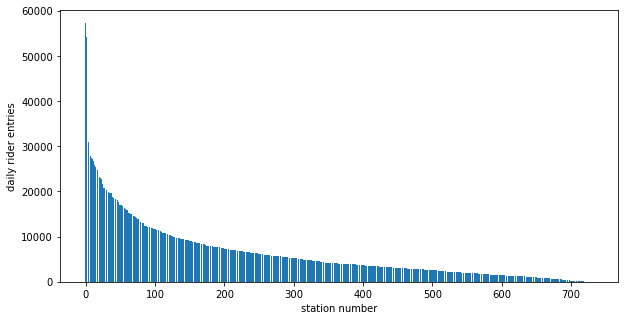

In [66]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = range(len(station_list))
y = [station_list[i][0] for i in range(len(station_list))]
plt.rcParams['figure.figsize'] = [10,5]
plt.bar(x,y)
plt.xlabel('station number')
plt.ylabel('daily rider entries')


### FULL STATION TOTALS
There are still several station areas within a station. Let's make a total dictionary that contains the total rider exits through each station. Then let's sort it:

In [71]:
total_dict = {}
for item in station_list:
    total_dict[item[1][2]] = int(total_dict.get(item[1][2],0) + item[0])
    
rider_list = []
for station, riders in total_dict.items():
    rider_list.append((riders, station))

rider_list.sort(reverse = True)
for rider_info in rider_list:
    print(rider_info)

(136834, '34 ST-PENN STA')
(135077, 'GRD CNTRL-42 ST')
(109563, '34 ST-HERALD SQ')
(91048, 'TIMES SQ-42 ST')
(88400, '14 ST-UNION SQ')
(85480, '23 ST')
(81102, 'FULTON ST')
(72934, '42 ST-PORT AUTH')
(72796, '86 ST')
(62141, '47-50 STS ROCK')
(58523, '125 ST')
(57270, 'PATH NEW WTC')
(57251, '59 ST')
(55966, '59 ST COLUMBUS')
(55860, 'CANAL ST')
(50766, 'CHAMBERS ST')
(48903, '96 ST')
(47857, '14 ST')
(47196, 'LEXINGTON AV/53')
(46467, '72 ST')
(46095, 'FLUSHING-MAIN')
(43671, 'WALL ST')
(42835, '28 ST')
(40872, '42 ST-BRYANT PK')
(39204, 'ATL AV-BARCLAY')
(38847, '50 ST')
(37885, 'JKSN HT-ROOSVLT')
(36072, 'W 4 ST-WASH SQ')
(35474, '7 AV')
(33735, 'JAMAICA CENTER')
(30358, '145 ST')
(29966, 'BOWLING GREEN')
(29226, '77 ST')
(28806, 'BEDFORD AV')
(28599, '5 AV/53 ST')
(27561, 'KEW GARDENS')
(27378, 'JOURNAL SQUARE')
(27153, 'LEXINGTON AV/63')
(27060, "B'WAY-LAFAYETTE")
(27058, 'CHURCH AV')
(26265, '8 AV')
(25904, 'KINGS HWY')
(25459, 'GRAND ST')
(25166, '72 ST-2 AVE')
(23761, 'BOROUGH 

Let's make a histogram of station totals:

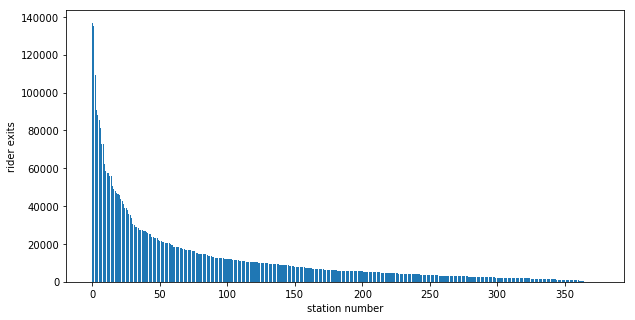

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

station = range(len(rider_list))
riders = [rider_list[i][0] for i in station]

plt.rcParams['figure.figsize'] = [10,5]
plt.bar(station, riders)
plt.xlabel('station number')
plt.ylabel('rider exits')


## Commuter?

Let's create a commuter index to be the average weekday exits divided by (avg weekday exits + avg weekend exits). To do this, we'll first make functions that test whether a date is a weekday or not and get the day of week (Sunday, Monday, etc.)

In [74]:
def isWeekday(t): #Input: Datetime object Output: True if it is weekday, False otherwise
    s = int(t.strftime("%w"))
    #print(s)
    if(s>=1 and s<=5):
        return True
    return False

def getDayOfWeek(t): # 0: Sunday
    return int(t.strftime("%w"))

#Example Usage
d1 = dt(2017,6,12,0,0,0)
print(isWeekday(d1))

True


Now let's make the commuter index:

In [75]:
oneDay = dt(2017,6,13,0,0,0)-dt(2017,6,12,0,0,0)
#print(oneDay)

import numpy as np
def getCommuteIndex(st):
    startDate = dt(2017,6,10,0,0,0)
    weekday = []
    weekend = []
    for i in range(21):
        people = getStationRangeRider(bigDict[st],startDate,startDate+oneDay)
        if(isWeekday(startDate)):
            weekday.append(people)
        else:
            weekend.append(people)
        startDate += oneDay
    dayavg = np.average(weekday)
    endavg = np.average(weekend)
    if(endavg==0):
        return 0
    #print("At",st,dayavg,endavg)
    idx = dayavg/(dayavg+endavg)
    return idx

#Example Usage
q = getCommuteIndex(('PTH11', 'R545', '14TH STREET'))
print(q)

0.6630820614974464


Let's get the commuter index for all of the station areas:

In [76]:
commuteRanking = []
for k in bigDict.keys():
    idx = getCommuteIndex(k)
    commuteRanking.append((idx,k))
commuteRanking.sort(reverse = True)
for k in commuteRanking:
    print(k[0],k[1])

0.9997511653754915 ('R634', 'R069', 'NEW LOTS AV')
0.9992930863848438 ('R242A', 'R049', '51 ST')
0.9992276202981386 ('R204A', 'R043', 'WALL ST')
0.9991714603602964 ('R237', 'R046', 'GRD CNTRL-42 ST')
0.9990563070147845 ('N412', 'R299', 'BROADWAY')
0.999009861776704 ('R230', 'R143', '28 ST')
0.9988500837796104 ('R633', 'R068', 'VAN SICLEN AV')
0.9987639060568604 ('R137', 'R031', '34 ST-PENN STA')
0.9983459591782725 ('R629', 'R065', 'ROCKAWAY AV')
0.9972474538948527 ('R632', 'R067', 'PENNSYLVANIA AV')
0.9970398631758979 ('N405', 'R239', 'GREENPOINT AV')
0.9965086507874932 ('C016', 'R278', '25 ST')
0.9961351862511307 ('R628', 'R064', 'SARATOGA AV')
0.9960146660290132 ('N318', 'R298', 'NORTHERN BLVD')
0.9957847095886765 ('N415', 'R286', 'MYRTLE-WILLOUGH')
0.9956817559454848 ('R112A', 'R027', 'WALL ST')
0.9954828418571167 ('N508', 'R453', '23 ST')
0.9937185929648241 ('N414', 'R316', 'FLUSHING AV')
0.9921383647798743 ('N414A', 'R316', 'FLUSHING AV')
0.9913849588662121 ('N408A', 'R256', 'NASS

0.5553784960538038 ('N025', 'R102', '125 ST')
0.5552036105417882 ('B031', 'R172', 'BRIGHTON BEACH')
0.5548504079782413 ('N119', 'R199', 'KINGSTON-THROOP')
0.5543557321098864 ('R253', 'R181', '110 ST')
0.5542068984860915 ('R527', 'R122', '90 ST-ELMHURST')
0.5540122619499755 ('R186', 'R036', 'DYCKMAN ST')
0.5533726685253626 ('N026', 'R102', '125 ST')
0.5529863823666151 ('R529', 'R208', '103 ST-CORONA')
0.5523546662066586 ('C022', 'R212', '59 ST')
0.5522993165759296 ('N544', 'R289', 'FT HAMILTON PKY')
0.5507583913467382 ('N506', 'R022', '34 ST-HERALD SQ')
0.5506345506345506 ('J034', 'R007', '104 ST')
0.5501758403533165 ('R606', 'R225', 'HOYT ST')
0.5499350086655113 ('H037', 'R349', 'SUTTER AV')
0.5498832842788999 ('G001', 'R151', 'CONEY IS-STILLW')
0.5498503338705963 ('J012', 'R379', 'KOSCIUSZKO ST')
0.5491540219261084 ('N057', 'R188', '50 ST')
0.548840729822325 ('N701', 'R571', '86 ST-2 AVE')
0.5481699585570713 ('C021', 'R212', '59 ST')
0.5478514171503902 ('N335', 'R158', 'KEW GARDENS')


Remember that there are still several station areas within each station. Let's get all of the commuter indexes for each station area and then take the median of that commuter index to assign to the entire station:

In [77]:
commuter_dict = {}
for station in bigDict.keys():
    idx = getCommuteIndex(station)
    commuter_dict[station[2]] = commuter_dict.get(station[2], []) + [idx]

commuter_list = []
for station, indexes in commuter_dict.items():
    commuter_list.append((np.median(indexes), station))

commuter_list.sort(reverse = True)

for info in commuter_list:
    print(info)

(0.9997511653754915, 'NEW LOTS AV')
(0.9972474538948527, 'PENNSYLVANIA AV')
(0.9970398631758979, 'GREENPOINT AV')
(0.9961351862511307, 'SARATOGA AV')
(0.9921383647798743, 'FLUSHING AV')
(0.9918046924566759, 'MYRTLE-WILLOUGH')
(0.9913849588662121, 'NASSAU AV')
(0.9353417649566577, 'BAY 50 ST')
(0.9308408339103008, 'BOWLING GREEN')
(0.891933474979852, '25 AV')
(0.861607050713121, 'THIRTY ST')
(0.852875091487838, '5 AV/53 ST')
(0.8420157984201581, 'LACKAWANNA')
(0.8378077200096461, 'WALL ST')
(0.8260323427878745, 'NEWARK HW BMEBE')
(0.816057346842834, 'FULTON ST')
(0.8108931354836424, 'NORTHERN BLVD')
(0.8106149103362604, '47-50 STS ROCK')
(0.8074075998026026, 'LEXINGTON AV/53')
(0.8051772157914188, '25 ST')
(0.8018751483867965, 'BROADWAY')
(0.7997926788255938, 'FRANKLIN ST')
(0.7996845425867507, 'HUNTERS PT AV')
(0.7979288286024461, 'VAN SICLEN AV')
(0.7947325761967224, 'UNION ST')
(0.794695345234983, 'HOUSTON ST')
(0.7899727167130391, 'ELMHURST AV')
(0.7875319527816872, 'PATH WTC 2')
(0